# PACPaper Result 2

#### Written by: David C.C. Lu

This notebook consists of details on the analysis of the result 2 in PAC paper.

For more information on PAC, read the following notebooks:
* [Notes on PAC generator](Notes_PAC_Generator.ipynb)
* [Notes on PAC methods](Notes_PAC_Method.ipynb)
* [Notes on PAC Methods Compare](Notes_PAC_Result1.ipynb) (Optional)

# Overview

This notebook shows the analysis of PAC on a recorded PD signal. 

* [Load Data](#load_data)
* [Analysis](#analysis)
* [Plot Results](#plot_results)

In [1]:
# Import all system modules
import os
import sys

# Import all scientific modules
import numpy as np
from pytf import FilterBank
from mspacman import PhaseAmplitudeCoupling

import mne
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

<a id=load_data></a>
# Load Data

In [2]:
depth = '07661'
data_path = os.getcwd()
fname = os.path.join(data_path, 'data', 'mer_{}_raw.fif'.format(depth))

raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /Users/davidlu/Developer/PhD Projects/notes_mspacman/data/mer_07661_raw.fif...
Isotrak not found
    Range : 0 ... 2600336 =      0.000 ...   108.347 secs
Ready.
Reading 0 ... 2600336  =      0.000 ...   108.347 secs...


<a id=analysis></a>
# Analysis

In [3]:
#################################
# Analysis Properties
#################################
split = 4
window_size = 4     # in seconds
t_start = 4
t_seg = [t_start, split * window_size + t_start]

# PAC Properties
Nbins = 10

#################################
# Grab the data
#################################
dat = raw.get_data()

print(raw.info.keys())
tmp = np.atleast_2d(dat[0,:])
fs = int(raw.info['sfreq'])

nch, nsamp = tmp.shape
t = np.arange(nsamp) / fs

ch = 0

dict_keys(['file_id', 'events', 'hpi_results', 'hpi_meas', 'subject_info', 'hpi_subsystem', 'proc_history', 'meas_id', 'experimenter', 'description', 'proj_id', 'proj_name', 'meas_date', 'sfreq', 'highpass', 'lowpass', 'line_freq', 'gantry_angle', 'chs', 'dev_head_t', 'ctf_head_t', 'dev_ctf_t', 'dig', 'bads', 'ch_names', 'nchan', 'projs', 'comps', 'acq_pars', 'acq_stim', 'custom_ref_applied', 'xplotter_layout', 'kit_system_id', 'buffer_size_sec'])


In [4]:
dp = 3
da = 30
fpsize = 40
fasize = 60

p_range = (6, 50)
a_range = (60, 500)

fp = np.arange(*p_range, np.diff(p_range)/fpsize, dtype=int)
fa = np.arange(*a_range, np.diff(a_range)/fasize, dtype=int)

f_lo = np.asarray([(p-dp, p+dp) for p in fp])
f_hi = np.asarray([(a-da, a+da) for a in fa])

In [5]:
# ===============================================================
# The Processing of segmented data length
# ===============================================================
#################################
# Taking a signal from data bank
#################################
ixd = -9 # the index for the interested signal in the bank

dat = np.atleast_2d(tmp[ch,fs*t_seg[0]:fs*t_seg[-1]])
dat_seg = dat.reshape(split, fs*window_size)

Nsamp_seg = dat_seg.shape[-1]

t = np.linspace(t_seg[0], t_seg[-1], int(fs * np.diff(t_seg)))

#################################
# Process Comodulogram
#################################
comod = PhaseAmplitudeCoupling(nch=dat.shape[0], nsamp=dat.shape[-1], binsize=2**15, freq_phase=f_lo, freq_amp=f_hi,\
                               sample_rate=fs, nprocs=3, pac='mi', mprocs=True)

comod_full = comod.comodulogram(dat)
comod.kill()
print(comod_full.shape, dat.shape)

comod_ = PhaseAmplitudeCoupling(nch=dat_seg.shape[0], nsamp=dat_seg.shape[-1], binsize=2**15, freq_phase=f_lo, freq_amp=f_hi,\
                                sample_rate=fs, nprocs=3, pac='mi', mprocs=True)
comod_seg = comod_.comodulogram(dat_seg)
print(comod_seg.shape, dat_seg.shape)
comod_.kill()

#################################
# Process segments of data
#################################
Nwinsize    = int((fs) * window_size)
stride      = int((fs) * .25)

print('\n')
print('#'*50)
print('Processing Segments of signal: ')
print('#'*50)
print('  Window Size: {} [s]'.format(Nwinsize/fs))
print('  Step Size:   {} [s]'.format(stride/fs))

dat_win = []
segments = []
for ix, i in enumerate(range(0, int((fs)*(t_seg[-1]-t_start)), stride)):
    i += (fs*t_seg[0])
    if i+Nwinsize <= (fs)*t_seg[-1]:
        dat_win += [tmp[ch,i:i+Nwinsize]]

        segments  += [(i+Nwinsize/2)/(fs)]
dat_win = np.asarray(dat_win)
segments = np.asarray(segments)
print(dat_win.shape, segments.shape, tmp.shape)

pac_ = PhaseAmplitudeCoupling(nch=dat_win.shape[0], nsamp=dat_win.shape[-1], binsize=2**15, freq_phase=[(10, 30)], freq_amp=[(60, 180)],\
                              sample_rate=fs, mprocs=False, nprocs=1, pac='mi')

mi1_seg = pac_.comodulogram(dat_win)[:,0,0]

(1, 40, 60) (1, 384000)
(4, 40, 60) (4, 96000)


##################################################
Processing Segments of signal: 
##################################################
  Window Size: 4.0 [s]
  Step Size:   0.25 [s]
(49, 96000) (49,) (1, 2600337)


/Users/davidlu/.virtualenvs/py-phd/lib/python3.6/site-packages/mspacman-0.1-py3.6.egg/mspacman/utilities/parallel.py:35: UserWarning: The multiprocessing is disabled! To enable multiprocessing, specify 'ins_shape' and 'out_shape' for preallocating shared memory.


<a id=plot_results></a>
# Plot Results

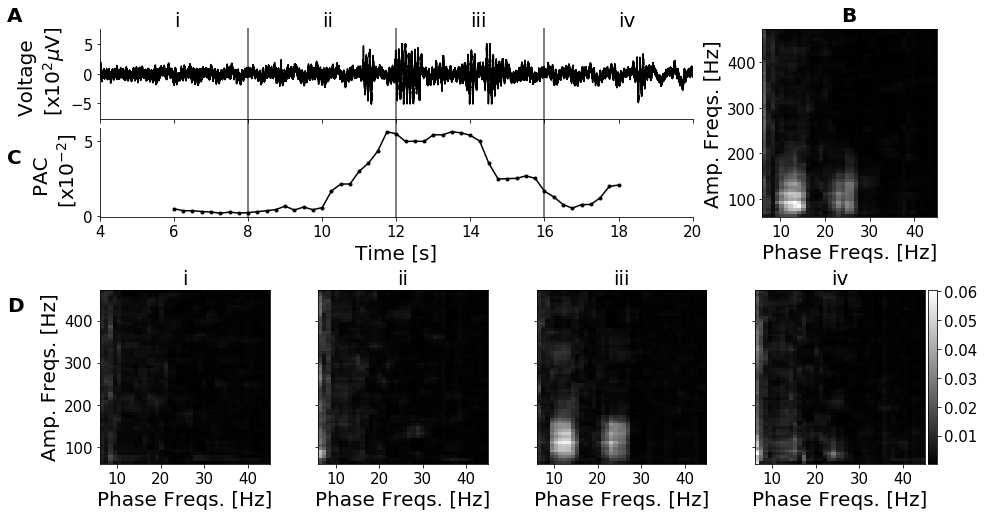

In [10]:
fontsize = dict(
    axis_label  = 20,
    title_label = 20,
    tick_label  = 15,
    fign_label  = 20
)

pac_scale = 100
amp_scale = 100

tmp = dat.copy()
tmp /= amp_scale
#################################
# Create the plots of fig1
#################################
fig_result2 = plt.figure(figsize=(15,8))

# Organize Subplots
outer = GridSpec(3, 1, height_ratios = [.5, .5, 1.5], hspace=.75) 
gs1_result2 = GridSpecFromSubplotSpec(2, 3, subplot_spec=outer[:2,:], width_ratios=[2,1,1], wspace=.3, hspace=.1)
gs2_result2 = GridSpecFromSubplotSpec(1, split, subplot_spec=outer[2,:])

ax1_result2 = plt.subplot(gs1_result2[0, :-1])
ax2_result2 = plt.subplot(gs1_result2[:, -1])
ax3_result2 = plt.subplot(gs1_result2[1, :-1])

ax5_result2 = [i for i in range(split)]
for i in range(split):
    ax5_result2[i] = plt.subplot(gs2_result2[0,i])

# Plotting the data
ax1_result2.plot(t, tmp.T, c='k')
im0 = ax2_result2.imshow(comod_full[0,:,:].T, origin='lower', interpolation=None,
                    vmin=comod_full.min(), vmax=comod_full.max(),
                     extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')

ax3_result2.plot(segments, mi1_seg * pac_scale, '.-', c='k')

# Plotting the Data
im = [ax.imshow(comod_seg[ti,:,:].T, origin='lower', interpolation=None,
                     vmin=comod_seg.min(), vmax=comod_seg.max(),
                     extent=[fp[0],fp[-1],fa[0],fa[-1]], aspect='auto', cmap='gray')
 for (ti,), ax in np.ndenumerate(ax5_result2)]

# Annotating plots
ax1_result2.text(t_seg[0]-2.5, tmp.max()*1.75, 'A', fontsize=fontsize['title_label'], weight='bold')
ax1_result2.text(t_seg[0]-2.5, -15, 'C', fontsize=fontsize['title_label'], weight='bold')
ax1_result2.text(24, tmp.max()*1.75, 'B', fontsize=fontsize['title_label'], weight='bold')
ax1_result2.text(t_seg[0]-2.5, -40, 'D', fontsize=fontsize['title_label'], weight='bold')

for ti in range(split):
    ax1_result2.text(np.mean([(window_size*ti), window_size*(ti+1)])+t_seg[0], tmp.max()*1.6, ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii'][ti], fontsize=20)
    
    if ti:
        ax1_result2.axvline(x=(ti+1)*(window_size),ymin=-.1,c="C7",linewidth=2,zorder=0, clip_on=False)
        ax3_result2.axvline(x=(ti+1)*(window_size),ymin=0,c="C7",linewidth=2,zorder=0, clip_on=False)

# Subplots properties
# Axes limits
ax1_result2.set_xlim([t[0],t[-1]])
ax1_result2.set_ylim([tmp.min()*1.5, tmp.max()*1.5])

ax3_result2.set_xlim([t[0],t[-1]])

# Axes labels
ax1_result2.set_ylabel('Voltage \n [x$10^{}\mu$V]'.format(int(np.log10(amp_scale))), fontsize=fontsize['axis_label'])

ax2_result2.set_xlabel('Phase Freqs. [Hz]', fontsize=fontsize['axis_label'])
ax2_result2.set_ylabel('Amp. Freqs. [Hz]', fontsize=fontsize['axis_label'])
# ax2_result2.set_title('PAC', fontsize=20)
ax2_result2.set_yticks([100, 200, 300, 400])

ax3_result2.set_xlabel('Time [s]', fontsize=fontsize['axis_label'])
ax3_result2.set_ylabel('PAC \n [x$10^{-2}$]', fontsize=fontsize['axis_label'])
ax3_result2.set_yticks([0, 5])

# Cleaning Plots
ax1_result2.spines['top'].set_visible(False)
ax1_result2.spines['right'].set_visible(False)
ax1_result2.set_yticks([-500/amp_scale, 0, 500/amp_scale])
for tick in ax1_result2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])
for tick in ax1_result2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])

ax1_result2.set_xticklabels('')

ax3_result2.spines['top'].set_visible(False)
ax3_result2.spines['right'].set_visible(False)
for tick in ax3_result2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])
for tick in ax3_result2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])
    
for tick in ax2_result2.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])
for tick in ax2_result2.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize['tick_label'])
    
# Axes labels
[ax.set_title(['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii'][ti], fontsize=20) for (ti,), ax in np.ndenumerate(ax5_result2)]
[ax.set_xlabel('Phase Freqs. [Hz]', fontsize=fontsize['axis_label']) for ax in ax5_result2]
[ax.set_xticks([10, 20, 30, 40]) for ax in ax5_result2]

for ix, ax in enumerate(ax5_result2):
    if ix == 0:
        ax.set_yticks([100, 200, 300, 400])
        ax.set_ylabel('Amp. Freqs. [Hz]', fontsize=fontsize['axis_label'])
    else:
        ax.set_yticks([100, 200, 300, 400])
        ax.set_yticklabels('')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize['tick_label'])

divider = [make_axes_locatable(ax) for ax in ax5_result2]
cax = [div.append_axes("right", size="5%", pad=0.05) for div in divider]

# Create second colorbar
cbar = fig_result2.colorbar(im[-1], cax = cax[-1])
fig_result2.delaxes(fig_result2.axes[7])
fig_result2.delaxes(fig_result2.axes[7])
fig_result2.delaxes(fig_result2.axes[7])

cbar.ax.tick_params(labelsize=fontsize['tick_label']) 

In [11]:
# save_plot = False

# #################################
# # Save both figures
# #################################
# path_to_save1 = os.path.realpath(os.path.join(os.getcwd(),'..', 'papers','pacpaper','resources','pac_result2.eps'))
# if save_plot:
#     fig_result2.savefig(path_to_save1)

In [ ]:

# Load the second .fif file and select channel 'C4'
file_path = "H:/My Drive/VHP F2HEAL TEAM/08_EEG Feedback/FreeEEG32/py3/pd6off_isotrak_raw.fif"
raw = mne.io.read_raw_fif(file_path, preload=True)

# Select the 'C4' channel
raw.pick_channels(['C4'])

# Verify the data
print(raw.info)


In [ ]:

# Preprocess data: Filter into phase (theta) and amplitude (gamma) bands
theta_band = (4, 8)  # Theta band for phase extraction
gamma_band = (30, 80)  # Gamma band for amplitude extraction

# Apply bandpass filters
theta_signal = raw.copy().filter(theta_band[0], theta_band[1], method='iir')
gamma_signal = raw.copy().filter(gamma_band[0], gamma_band[1], method='iir')

# Extract phase and amplitude using Hilbert transform
theta_phase = np.angle(mne.filter.hilbert(theta_signal.get_data()[0]))
gamma_amplitude = np.abs(mne.filter.hilbert(gamma_signal.get_data()[0]))

# Compute PAC using mspacman
pac = PhaseAmplitudeCoupling(fs=raw.info['sfreq'], low_fq_range=theta_band, high_fq_range=gamma_band)
modulation_index = pac.fit(theta_phase, gamma_amplitude)

# Display results
print(f"Modulation Index for 'C4': {modulation_index}")


In [ ]:

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(theta_phase[:1000], label='Theta Phase (C4)')
plt.plot(gamma_amplitude[:1000], label='Gamma Amplitude (C4)')
plt.xlabel('Time (samples)')
plt.ylabel('Signal')
plt.title('Theta Phase and Gamma Amplitude for Channel C4')
plt.legend()
plt.show()
